In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from src.var_selection import   prepare_model_data, initiate_models, \
                                apply_forward_selection, save_SFS_iteration, \
                                apply_lassoCV, save_lasso_iter
from src.model_performance_plots import plot_optimum_models, plot_all_models
from src.pca import get_cmap
import configparser
from src.pca import get_cmap
from sklearn.metrics import mean_squared_error





In [2]:
def filter_predictors(X,var_names,var_select):
    return (pd.DataFrame(data = X, columns = var_names)[var_select]).to_numpy()

In [3]:
matrix_file = './Outputs/Event_Matrix.csv'

# read data, split train and test and normalize using sklearn.preprocessing.StandardScaler()
X_train, X_test, y_train, y_test, var_names, group_names = prepare_model_data(data_file = matrix_file, test_size = 0.2)

print("Number of predictors: ", X_train.shape[1])

print("Number of training samples: ", X_train.shape[0])

print("Number of testing samples: ", X_test.shape[0])

Number of predictors:  45
Number of training samples:  60
Number of testing samples:  15


In [5]:
selected_predictors = {"RandomForestRegressor": ["P_15h_acum",'bf_qf_peak_ratio',"P_15h_mean_i"],
                        "KNeighborsRegressor" : ["P_20h_acum","max_qf","peakFlow"],
                        "GradientBoostingRegressor": ["P_20h_acum","P_15h_mean_i", "Tf_bf_peak_ratio"],
                        # "GradientBoostingRegressor": var_names
                        }

In [9]:
# Just fit the models
model_list = initiate_models()

predictions = {}
for model in model_list:
    model_name = model.__class__.__name__
    X_train_in = filter_predictors(X_train, var_names, selected_predictors[model_name])
    X_test_in  = filter_predictors(X_test, var_names, selected_predictors[model_name])
    model.fit(X_train_in, y_train)
    yhat_train = model.predict(X_train_in)
    yhat_test = model.predict(X_test_in)
    predictions[model_name] = {"train":yhat_train, "test": yhat_test}

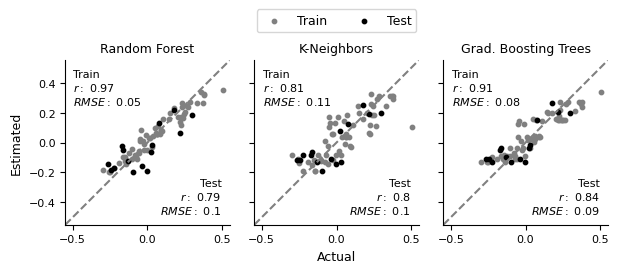

In [10]:
fig, axs = plt.subplots(1,3, figsize = (7,2.4), sharey = True)
config = configparser.ConfigParser()
config.read('fig_params.txt')
font_sizes = config["Fonts_paper"]
titles = ["Random Forest", "K-Neighbors", "Grad. Boosting Trees"]
for ax, title, (model_name, model_predictions) in zip(axs,titles,predictions.items()):
    
    ax.scatter(y_train, model_predictions["train"], color = "grey", label = "Train", s = 10 )
    ax.scatter(y_test, model_predictions["test"], color = "k", label = "Test", s = 10 )
    ax.set_xlim(-0.55, 0.55)
    ax.set_ylim(-0.55, 0.55)
    ax.axline(xy1 = (0,0), slope = 1, color = "grey", linestyle = "--")
    ax.set_aspect("equal")
    ax.set_title(title, fontsize = font_sizes.getint("title"))
    ax.tick_params(labelsize = font_sizes.getint("tick_label"))
    ax.spines[['right', 'top']].set_visible(False)

    train_corr = np.corrcoef(y_train, model_predictions["train"])[0,1]
    test_corr = np.corrcoef(y_test, model_predictions["test"])[0,1]

    train_rms = mean_squared_error(y_train, model_predictions["train"], squared=False)
    test_rms = mean_squared_error(y_test, model_predictions["test"], squared=False)
    
    ax.annotate(f"Train\n$r:$ {round(train_corr,2)}\n$RMSE:$ {round(train_rms,2)}", xy = (0.05,0.95), xycoords = "axes fraction", ha = "left", va="top", fontsize = font_sizes.getint("annotation"))
    ax.annotate(f"Test\n$r:$ {round(test_corr,2)}\n$RMSE:$ {round(test_rms,2)}", xy = (0.95,0.05), xycoords = "axes fraction", ha = "right", va="bottom", fontsize = font_sizes.getint("annotation"))

axs[1].set_xlabel("Actual", fontsize = font_sizes.getint("label"))
axs[0].set_ylabel("Estimated", fontsize = font_sizes.getint("label"))
axs[1].legend(loc = "upper center",fontsize = font_sizes.getint("label"), bbox_to_anchor = (0.5,1.35), ncols = 2)
fig.subplots_adjust(wspace = 0.15)

plt.savefig("./Outputs/Figures/Train-test_score.png", dpi = 300, facecolor = "white", bbox_inches = "tight") 
    

In [13]:
from sklearn.model_selection import GridSearchCV

model_list = initiate_models()

# parameters = {{'kernel':('linear', 'rbf'), 'C':[1, 10]}}
parameters = {"RandomForestRegressor": {"n_estimators": [30, 60, 90, 120, 150], "max_features": ["sqrt", "log2", 1.0], "max_samples": [0.5,0.75,1.0] },
              "KNeighborsRegressor" : {"n_neighbors": [4,5,6]},
              "GradientBoostingRegressor": {"learning_rate": [0.001, 0.01, 0.1, 1], "n_estimators": [20, 40, 60, 80, 100], "max_depth": [1,2,3]}
            }
grid_search_results = {}
for model in model_list:
  print(f"Running: {model.__class__.__name__}")
  X_train_in = filter_predictors(X_train, var_names, selected_predictors[model_name])
  clf = GridSearchCV(model, parameters[model.__class__.__name__])
  clf.fit(X_train_in, y_train)
  grid_search_results[model.__class__.__name__] = clf

Running: RandomForestRegressor
Running: KNeighborsRegressor
Running: GradientBoostingRegressor


In [17]:
grid_search_results["GradientBoostingRegressor"].best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 20}

In [12]:
model_list[0].__class__.__name__

'RandomForestRegressor'

In [ ]:
# Just fit the models
model_list = initiate_models()
for iteration in range(10):
    r = []
    estimators = range(10,100,5)
    for n_estimators in estimators:
        model_list[-1].set_params(**{'n_estimators': n_estimators, 'max_depth': 2})

        predictions = {}
        for model in model_list[-1:]:
            model_name = model.__class__.__name__
            X_train_in = filter_predictors(X_train, var_names, selected_predictors[model_name])
            X_test_in  = filter_predictors(X_test, var_names, selected_predictors[model_name])
            model.fit(X_train_in, y_train)
            yhat_train = model.predict(X_train_in)
            yhat_test = model.predict(X_test_in)
            predictions[model_name] = {"train":yhat_train, "test": yhat_test}
            r.append(np.corrcoef(yhat_test, y_test)[0,1])

    plt.plot(estimators, r,'.k')
